In [2]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt

In [3]:
cuda = torch.device('cuda')

In [7]:
import mnist

train_x, train_y, test_x, test_y = mnist.load()
train_x = torch.from_numpy(train_x / 255.0 - 0.5 * 2).float().cuda()

In [8]:
class Discriminator(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Linear(num_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.out = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

----

In [13]:
class Generator(nn.Module):
    def __init__(self, num_noise_features, num_features):
        super().__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Linear(num_noise_features, 256),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, num_features),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [58]:
def noise(num_noise, num_noise_features):
    return Variable(torch.randn(num_noise, num_noise_features, device=cuda))

-----------

In [32]:
discriminator = Discriminator(train_x.size(1)).cuda()
generator = Generator(100, train_x.size(1)).cuda()

In [56]:
loss = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

batch_size = 4096
for epoch in range(1000):
    print('Epoch: ', epoch+1, end='\r')
    permutation = torch.randperm(train_x.size(0))
    for i in range(0, train_x.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        real_data = train_x[indices]
        
        n = noise(real_data.size(0), 100)
        # Detach so that generator is not updated in this phase.
        fake_data = generator(n).detach()
        
        real_target = Variable(torch.ones(real_data.size(0), 1, device=cuda))
        fake_target = Variable(torch.zeros(real_data.size(0), 1, device=cuda))

        d_optimizer.zero_grad()
        
        output = discriminator(real_data)
        error_real = loss(output, real_target)
        error_real.backward()
        
        output = discriminator(fake_data)
        error_fake = loss(output, fake_target)
        error_fake.backward()
        
        d_optimizer.step()
        
        #####
        
        n = noise(real_data.size(0), 100)
        fake_data = generator(n)
        
        g_optimizer.zero_grad()
        
        output = discriminator(fake_data)
        error_generator = loss(output, real_target)
        error_generator.backward()
        
        g_optimizer.step()

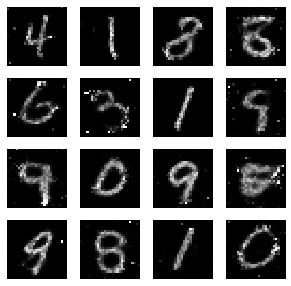

In [57]:
fig = plt.figure(figsize=(5, 5))
for i in range(16):
    sub = fig.add_subplot(4, 4, i + 1)
    sub.axis('off')
    n = noise(1, 100)
    image = generator(n).detach().cpu().numpy().reshape(28, 28)
    sub.imshow(image, cmap='gray')